In [1]:
import torch
import numpy as np
import time
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import csv
import pandas as pd
import skfuzzy as fuzz
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
dataset = pd.read_csv('xAPI-Edu-Data.csv')

In [3]:
dataset.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M


In [4]:
dataset.describe(include='all')

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
count,480,480,480,480,480,480,480,480,480,480.000000,480.000000,480.000000,480.000000,480,480,480,480
unique,2,14,14,3,10,3,12,2,2,NaN,NaN,NaN,NaN,2,2,2,3
top,M,KW,KuwaIT,MiddleSchool,G-02,A,IT,F,Father,NaN,NaN,NaN,NaN,Yes,Good,Under-7,M
freq,305,179,180,248,147,283,95,245,283,NaN,NaN,NaN,NaN,270,292,289,211
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.775000,54.797917,37.918750,43.283333,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.779223,33.080007,26.611244,27.637735,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.750000,20.000000,14.000000,20.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000000,65.000000,33.000000,39.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.000000,84.000000,58.000000,70.000000,NaN,NaN,NaN,NaN


In [5]:
imp_features = dataset.drop(['gender', 'NationalITy', 'Semester', 'PlaceofBirth', 'GradeID', 'Topic', 'SectionID', 'Relation'], axis=1)
stage_mapping = {"lowerlevel":0, "MiddleSchool":0.5, "HighSchool":1}
survey_mapping = {"No":0, "Yes":1}
satisfaction_mapping = {"Bad":0, "Good":1}
absence_mapping = {"Under-7":0, "Above-7":1}
class_mapping = {"L":0, "M":0.5, "H":1}
numeric_features = imp_features
numeric_features['StageID'] = imp_features['StageID'].map(stage_mapping)
numeric_features['ParentAnsweringSurvey'] = imp_features['ParentAnsweringSurvey'].map(survey_mapping)
numeric_features['ParentschoolSatisfaction'] = imp_features['ParentschoolSatisfaction'].map(satisfaction_mapping)
numeric_features['StudentAbsenceDays'] = imp_features['StudentAbsenceDays'].map(absence_mapping)
numeric_features['Class'] = imp_features['Class'].map(class_mapping)

In [6]:
numeric_features.describe(include='all')

,StageID,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.327083,46.775000,54.797917,37.918750,43.283333,0.562500,0.608333,0.397917,0.515625
std,0.301866,30.779223,33.080007,26.611244,27.637735,0.496596,0.488632,0.489979,0.374369
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,15.750000,20.000000,14.000000,20.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,50.000000,65.000000,33.000000,39.000000,1.000000,1.000000,0.000000,0.500000
75%,0.500000,75.000000,84.000000,58.000000,70.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,100.000000,99.000000,98.000000,99.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
data_np_array = numeric_features.values
print(data_np_array.shape)
X1 = data_np_array[:,1:5]
X2 = np.concatenate((data_np_array[:,0:1],data_np_array[:,5:8]),axis=1)
Y = data_np_array[:,data_np_array.shape[1]-1:data_np_array.shape[1]]

(480, 9)


In [8]:
print(X1.shape)
print(X2.shape)
print(Y.shape)

(480, 4)
(480, 4)
(480, 1)


0.2


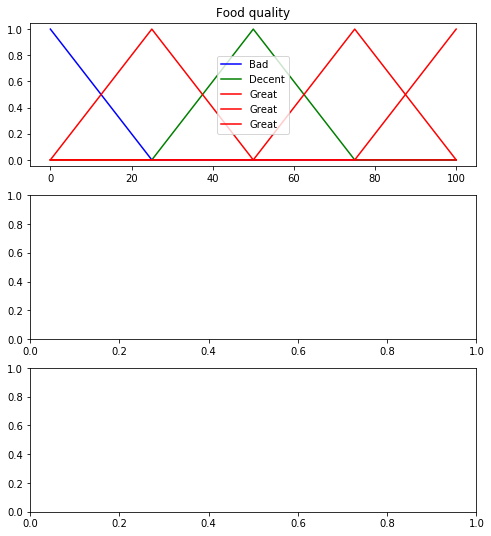

In [9]:
rng = np.arange(0, 101, 1)

vlo = fuzz.trimf(rng, [0, 0, 25])
lo = fuzz.trimf(rng, [0, 25, 50])
md = fuzz.trimf(rng, [25, 50, 75])
hi = fuzz.trimf(rng, [50, 75, 100])
vhi = fuzz.trimf(rng, [75, 100, 100])

level_lo = fuzz.interp_membership(rng, vhi, 80)
print (level_lo)

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))

ax0.plot(rng, vlo, 'b', linewidth=1.5, label='Bad')
ax0.plot(rng, md, 'g', linewidth=1.5, label='Decent')
ax0.plot(rng, hi, 'r', linewidth=1.5, label='Great')
ax0.plot(rng, vhi, 'r', linewidth=1.5, label='Great')
ax0.plot(rng, lo, 'r', linewidth=1.5, label='Great')
ax0.set_title('Food quality')
ax0.legend()
plt.show()

In [10]:
dataSize=480
x=np.zeros((dataSize,20))
for i in range(dataSize):
    for j in range(4):
        x[i,j*5]=fuzz.interp_membership(rng, vlo, X1[i,j])
        x[i,j*5+1]=fuzz.interp_membership(rng, lo, X1[i,j])
        x[i,j*5+2]=fuzz.interp_membership(rng, md, X1[i,j])
        x[i,j*5+3]=fuzz.interp_membership(rng, hi, X1[i,j])
        x[i,j*5+4]=fuzz.interp_membership(rng, vhi, X1[i,j])

In [11]:
print (x.shape)
X=np.concatenate((x,X2),axis=1)
print (X.shape)

(480, 20)
(480, 24)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)
y_train= torch.squeeze(y_train,dim=1)
y_test= torch.squeeze(y_test,dim=1)
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

torch.Size([384, 24])
torch.Size([96, 24])
torch.Size([384])
torch.Size([96])


In [13]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder=nn.Linear(24,8)
        self.decoder=nn.Linear(8,24)
        self.l1=nn.Linear(8,64)
        self.l2=nn.Linear(64,3)
        self.soft=nn.Softmax()
    def forward(self, x):
        x1=self.encoder(x)
        x=self.decoder(x1)
        y=self.l1(x1)
        y=self.l2(y)
        y=self.soft(y)
        return x,y

In [14]:
class test(nn.Module):
    def __init__(self):
        super(test, self).__init__()
        self.encoder=nn.Sequential(
            nn.Linear(24,8),
        )
        
        self.decoder=nn.Sequential(
            nn.Linear(8,24),
        )
        
        self.classify = nn.Sequential(
            nn.Linear(8,64),
            nn.Linear(64,3),
            nn.Softmax(),
        )
        
    def forward(self, x):
        x1=self.encoder(x)
        x=self.decoder(x1)
        y=self.classify(x1)
        return x,y

In [15]:
x=torch.tensor(torch.rand(24))
net=test()
optimizer = optim.Adam(net.parameters(), lr=0.1)
y1,y2= net(Variable(x))
print(y1)
print(y2)

tensor([-0.3199, -0.2173,  0.2969, -0.1827, -0.3943, -0.1570,  0.1030, -0.3463,
         0.3898,  0.0678, -0.2861,  0.1317,  0.0696, -0.0544,  0.4380,  0.0065,
         0.4421, -0.0902,  0.0692, -0.0469, -0.2662,  0.1868, -0.1809, -0.0639],
       grad_fn=<AddBackward0>)
tensor([0.3193, 0.2974, 0.3833], grad_fn=<SoftmaxBackward>)


/home/sid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


/usr/local/lib/python3.5/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.10623295993233721
At Iteration: 1 /20  ;  Training Loss: 0.106233; Time consumed: 0m 0s 
0.09065876978759964
At Iteration: 2 /20  ;  Training Loss: 0.090659; Time consumed: 0m 0s 
0.08414318381498258
At Iteration: 3 /20  ;  Training Loss: 0.084143; Time consumed: 0m 0s 
0.08045310790960987
At Iteration: 4 /20  ;  Training Loss: 0.080453; Time consumed: 0m 0s 
0.07784150959923863
At Iteration: 5 /20  ;  Training Loss: 0.077842; Time consumed: 0m 0s 
0.07662141773228844
At Iteration: 6 /20  ;  Training Loss: 0.076621; Time consumed: 0m 0s 
0.0759833309178551
At Iteration: 7 /20  ;  Training Loss: 0.075983; Time consumed: 0m 0s 
0.07502482482232153
At Iteration: 8 /20  ;  Training Loss: 0.075025; Time consumed: 0m 0s 
0.07459283146696787
At Iteration: 9 /20  ;  Training Loss: 0.074593; Time consumed: 0m 0s 
0.07422865702149768
At Iteration: 10 /20  ;  Training Loss: 0.074229; Time consumed: 0m 0s 
0.07388175837695599
At Iteration: 11 /20  ;  Training Loss: 0.073882; Time consumed: 0m 0s

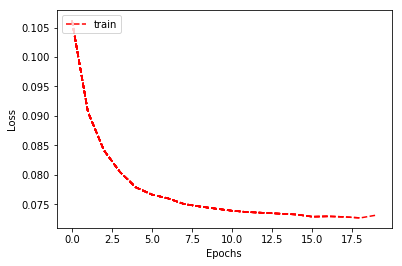

In [16]:
BatchSize=8
iterations = 20
lr=1e-3
w1=0.2
w2=0.8
dataSize2=X_train.shape[0]
criterion2=nn.CrossEntropyLoss()
criterion1=nn.MSELoss()
optimizer= optim.Adam(net.parameters(),lr=lr,betas=(0.9,0.99))

trainloss = []
start = time.time()


for epoch in range(iterations):
    epochStart = time.time()
    runningloss = 0
    net.train(True)   #train start
    rn=torch.randperm(dataSize2)
    X=X_train[rn]
    Y=y_train[rn]
    
    for i in range(0,dataSize2,BatchSize):
        if i+BatchSize>dataSize:
            inputs=X[i:]
            labels=Y[i:]
        else:
            inputs=X[i:i+BatchSize]
            #print(inputs.shape)
            labels=Y[i:i+BatchSize]
            #print(labels.shape)
        
        inputs, labels = Variable(inputs), Variable(labels)
        
        output1,output2 = net(inputs)
        #print(output2.shape)

        loss = w1*criterion1(output1, inputs)+w2*criterion2(output2,labels.long())
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        runningloss += loss.item()
        
    avgTrainloss = runningloss/dataSize2
    print (avgTrainloss)
    trainloss.append(avgTrainloss)
    
    fig1 = plt.figure(1)        
    plt.plot(range(epoch+1),trainloss,'r--',label='train')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')   
      
    epochEnd = time.time()-epochStart
    print('At Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f}; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTrainloss,epochEnd//60,epochEnd%60))
end = time.time()-start
print('Training completed in {:.0f}m {:.0f}s'.format(end//60,end%60))

In [17]:
def testNet(model, input_tensor, label_tensor, batchsize):

    model.eval()

    testsize = int(input_tensor.shape[0])

    corrects = 0.0
    
    with torch.no_grad():      
    
        for i in range(0, testsize, batchsize):

            if i+batchsize<=testsize:
                inputs = input_tensor[i:i+batchsize]
                labels = label_tensor[i:i+batchsize]

            else:
                inputs = input_tensor[i:]
                labels = label_tensor[i:]

            inputs, labels = Variable(inputs.float()), Variable(labels.long())                      

            # Feed-forward
            output1,output2 = model(inputs)

            _, predicted = torch.max(output2.data, 1)

            corrects += ((predicted==labels).sum(0)).float()

    return corrects/float(testsize)

In [18]:
accuracy=testNet(net, X_test, y_test, 1)

/usr/local/lib/python3.5/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [19]:
print(accuracy)

tensor(0.7917)
